In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import collections
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

2023-11-25 11:28:51.997727: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 11:28:52.456484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 11:28:52.456657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 11:28:52.556114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 11:28:52.763520: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 11:28:52.765085: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
rd_state = 666

In [3]:
# Manually look at images
if False:  
    dirpath = 'images/Images/%s' % labels[0].dir
    f = os.listdir(dirpath)[0]
    img = mpimg.imread('%s/%s' % (dirpath, f))
    plt.imshow(img)

In [4]:
# Load labels

Label = collections.namedtuple("Label", "id code name dir")

labels = []
reverse_labels = dict()

for id, dir in enumerate(os.listdir('images/Images/')):
    code, name = dir.split('-', 1)
    labels.append(Label(id, code, name, dir))
    reverse_labels[name] = id

NB_CLASSES = len(labels)

2023-11-25 11:29:00.118131: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 11:29:00.119468: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'Yorkshire_terrier'

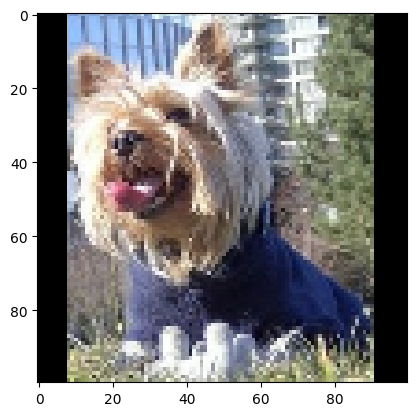

In [5]:
RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS = 100, 100, 3
SHUFFLE_SIZE = 1000
BATCH_SIZE = 32

@tf.py_function(Tout=tf.int32)
def label_to_int(lbl):
  return reverse_labels[lbl.numpy().decode('utf-8')]

def load_image(file_path):
  dir = tf.strings.split(file_path, os.sep)[-2]
  label = tf.strings.split(dir, '-', 1)[-1]
  label = label_to_int(label)
  label.set_shape(())
  img = tf.io.decode_jpeg(tf.io.read_file(file_path), channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize_with_pad(img, RESIZE_WIDTH, RESIZE_HEIGHT)
  img.set_shape((RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS))
  return img, label

#list_ds = tf.data.Dataset.list_files('images/Images/*/*').shuffle(SHUFFLE_SIZE)
#TOTAL_SIZE = list_ds.cardinality().numpy()
#labeled_ds = list_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = tf.data.Dataset.list_files('data/train/*/*').shuffle(SHUFFLE_SIZE).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.list_files('data/val/*/*').shuffle(SHUFFLE_SIZE).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.list_files('data/test/*/*').shuffle(SHUFFLE_SIZE).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

for img, lbl in train_ds.take(1):
  display(labels[lbl[0].numpy()].name)
  plt.imshow(img[0])

In [6]:
TEST_SIZE, VAL_SIZE, TRAIN_SIZE = test_ds.cardinality().numpy(), val_ds.cardinality().numpy(), train_ds.cardinality().numpy()
TOTAL_SIZE = TEST_SIZE + VAL_SIZE + TRAIN_SIZE

print("Total size: %s - Train size: %s" % (TOTAL_SIZE, TRAIN_SIZE))

Total size: 644 - Train size: 548


In [ ]:
# Checking that val, test and train are different

if False:
    import xxhash
    
    print("Computing fingerprints for all 3 sets")
    
    test_fingerprints = set()
    for imgs, _ in test_ds:
        for i in imgs:
            fp = xxhash.xxh128(i.numpy().tobytes())
            test_fingerprints.add(fp)
    
    print("Done computing test fingerprints")
    
    val_fingerprints = set()
    for imgs, _ in val_ds:
        for i in imgs:
            fp = xxhash.xxh128(i.numpy().tobytes())
            val_fingerprints.add(fp)
    
    print("Done computing val fingerprints")
    
    train_fingerprints = set()
    for imgs, _ in train_ds:
        for i in imgs:
            fp = xxhash.xxh128(i.numpy().tobytes())
            if fp in train_fingerprints:
                print("Duplicate: %s" % fp)
            train_fingerprints.add(fp)
    
    print("Done computing train fingerprints")
    print("")
    
    print("%s test, %s val, %s train" % (len(test_fingerprints), len(val_fingerprints), len(train_fingerprints)))
    
    print("Common train & val: %s" % len(train_fingerprints.intersection(val_fingerprints)))
    print("Common train & test: %s" % len(train_fingerprints.intersection(test_fingerprints)))
    print("Common test & val: %s" % len(test_fingerprints.intersection(val_fingerprints)))
    
    #print("Example common: %s" % test_fingerprints.intersection(val_fingerprints))

In [7]:
def label_str(label):
    return labels[label].name

for i in range(len(labels)):
    print("%s -> %s" % (i, label_str(i)))
    assert(i == reverse_labels[label_str(i)])

0 -> Tibetan_terrier
1 -> English_setter
2 -> keeshond
3 -> basenji
4 -> Pembroke
5 -> Siberian_husky
6 -> soft-coated_wheaten_terrier
7 -> Kerry_blue_terrier
8 -> Cardigan
9 -> Maltese_dog
10 -> Saint_Bernard
11 -> Labrador_retriever
12 -> bull_mastiff
13 -> Boston_bull
14 -> Chihuahua
15 -> komondor
16 -> Blenheim_spaniel
17 -> miniature_poodle
18 -> whippet
19 -> beagle
20 -> kuvasz
21 -> English_springer
22 -> Norwich_terrier
23 -> Gordon_setter
24 -> otterhound
25 -> dhole
26 -> Scottish_deerhound
27 -> African_hunting_dog
28 -> groenendael
29 -> silky_terrier
30 -> Samoyed
31 -> Chesapeake_Bay_retriever
32 -> miniature_schnauzer
33 -> Australian_terrier
34 -> Lakeland_terrier
35 -> Great_Pyrenees
36 -> cairn
37 -> Appenzeller
38 -> Border_collie
39 -> papillon
40 -> Yorkshire_terrier
41 -> Dandie_Dinmont
42 -> schipperke
43 -> Border_terrier
44 -> redbone
45 -> Shetland_sheepdog
46 -> malinois
47 -> toy_terrier
48 -> German_short-haired_pointer
49 -> wire-haired_fox_terrier
50 ->

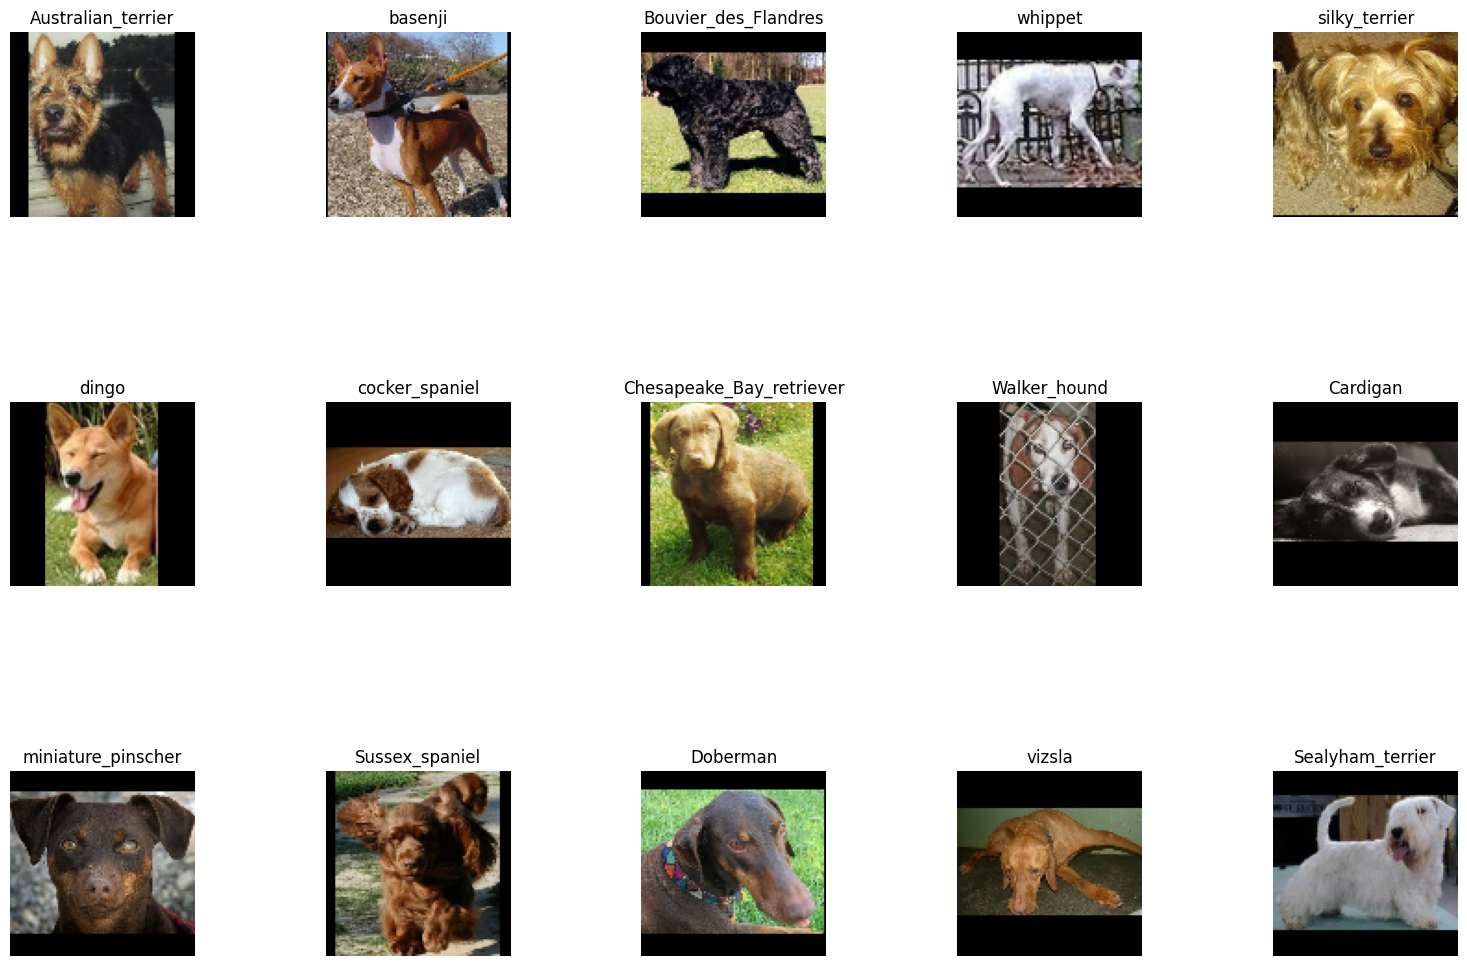

In [8]:
def show_items(inp, X, Y, label=None, labels=None, true_labels=None):
    fX = 20
    fY = int(fX*Y/X)

    figure, axis = plt.subplots(max(Y, 2), max(X, 2), figsize=(fX,fY))
    if label is not None:
        if not isinstance(label, str):
            label = label_str(label)
        figure.suptitle(label, y=0.9)
    plt.subplots_adjust(wspace=0.1, hspace=1)
    for x in range(X):
        for y in range(Y):
            axis[y, x].imshow(inp[y*X+x])
            axis[y, x].axis('off')
            if labels is not None:
                if true_labels is not None:
                    axis[y, x].set_title(label_str(labels[y*X+x]) + " != " + label_str(true_labels[y*X+x]))
                else:
                    axis[y, x].set_title(label_str(labels[y*X+x]))

# Let's peek at some random pictures
show_input = []
show_labels = []
for img, lbl in train_ds.take(1):
  for i, l in zip(img, lbl):
      show_labels.append(l)
      show_input.append(i.numpy())
show_items(show_input, 5, 3, labels=show_labels)

In [58]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    for k in history:
        label = 'Train %s' % k
        if 'val_' in k:
            label = 'Validation %s' % k.removeprefix('val_')
        if 'loss' in k:
            ax1.plot(history[k], label=label)
        if 'accuracy' in k:
            ax2.plot(history[k], label=label)

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Loss per epoch', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Accuracy per epoch', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True)

def evaluate_model(model):
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print('\nTest loss/accuracy: %s - %s' % (test_loss, test_acc))

In [52]:
# Model parameters

data_augmentation = True
regularization = True
#type = "stupid"
#type = "ffnn"  # Same as stupid
#type = "ffnn-120"
#type = "ffnn-2048"
#type = "ffnn-256"
type = "cnn-32#32-64#64-ffnn-128-128" # 0.3 in 250 epochs - heading towards 0.35
type = "cnn-32#32#32-64#64#64-ffnn-128-128"

suffix = ""
if data_augmentation:
    suffix += "_aug"
if regularization:
    suffix += "_reg"
model_file = '%s%s_model.keras' % (type, suffix)
history_file = model_file + '.history'

all_history = collections.defaultdict(list)

In [59]:
# Train a predictor

if os.path.exists(model_file):
    raise "Safety check: the model %s already exists" % model_file

sequence = []

if data_augmentation:
    max_rotation = 0.1
    max_translation = 0.1
    max_zoom = 0.1
    max_contrast = 0.1
    
    sequence.extend([
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomRotation((-max_rotation, max_rotation), fill_mode="nearest", interpolation="nearest"),
        tf.keras.layers.RandomTranslation((-max_translation, max_translation), (-max_translation, max_translation), fill_mode="nearest", interpolation="nearest"),
        tf.keras.layers.RandomZoom((-max_zoom, max_zoom), fill_mode="nearest", interpolation="nearest"),
        tf.keras.layers.RandomContrast(max_contrast),
    ])
    
if type == "stupid":
    # Very stupid feed-forward network
    sequence.extend([
        tf.keras.layers.Flatten(),
    ])
elif type.startswith("ffnn"):
    # Simple feed-forward network
    layers = type.split("-")[1:]
    sequence.extend([
        tf.keras.layers.Flatten(),
    ])
    for l in layers:
        sequence.extend([
            #tf.keras.layers.Dense(int(l), activation='relu'),
            tf.keras.layers.Dense(int(l)),
        ])
elif type.startswith("cnn"):
    noise = 0.1
    # A convolution neural network
    first = True
    cnn, ffnn = type.split("-ffnn-")
    steps = cnn.split("-")[1:]
    for s in steps:
        layers = s.split("#")
        for l in layers:
            input_shape = None
            if first:
                input_shape = [RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS]
            sequence.extend([
                tf.keras.layers.Conv2D(filters=int(l), kernel_size=(3,3), input_shape=input_shape, padding="same", activation="relu"),
            ])
        sequence.extend([
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
            tf.keras.layers.GaussianNoise(noise),
        ])
    sequence.extend([
        tf.keras.layers.Flatten(),
    ])
    layers = ffnn.split("-")
    for l in layers:
        sequence.extend([
            tf.keras.layers.Dense(int(l), activation="relu"),
        ])
else:
    raise "Unknown type '%s'" % type

if regularization:
    # Regularization
    sequence.extend([
        tf.keras.layers.GaussianNoise(0.1),
        tf.keras.layers.Dropout(0.2),
    ])
    
# Output
sequence.extend([
    tf.keras.layers.Dense(NB_CLASSES)
])

model = tf.keras.Sequential(sequence)

model.build(input_shape=[32, RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS])
#model.summary()
#top_5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_k_categorical_accuracy')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Loss and accuracy before any training
evaluate_model(model)

history = model.fit(train_ds, epochs=1, validation_data=val_ds)
all_history = history.history

# Loss and accuracy after a single round of training
evaluate_model(model)

model.save(model_file)
with open(history_file, 'wb') as f:
    pickle.dump(all_history, f)

63/63 - 6s - loss: 4.7880 - accuracy: 0.0050 - 6s/epoch - 92ms/step

Test loss/accuracy: 4.787971019744873 - 0.005002501420676708
548/548 [==============================] - 285s 517ms/step - loss: 4.7978 - accuracy: 0.0080 - val_loss: 4.7860 - val_accuracy: 0.0105
63/63 - 6s - loss: 4.7851 - accuracy: 0.0155 - 6s/epoch - 91ms/step

Test loss/accuracy: 4.785088062286377 - 0.015507753938436508


In [ ]:
# Or load last saved model
import pickle

model = tf.keras.models.load_model(model_file)
with open(history_file, 'rb') as f:
    all_history = pickle.load(f)
display(all_history)

In [ ]:
import pickle
import time

ITERS = 25
EPOCHS = 10
for i in range(ITERS):
    print("\n ===== %s/%s iterations =====\n" % (i, ITERS))
    this_history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    for k in this_history.history:
        all_history[k].extend(this_history.history[k])
    model.save(model_file)
    with open(history_file, 'wb') as f:
        pickle.dump(all_history, f)


 ===== 0/25 iterations =====

Epoch 1/10
548/548 [==============================] - 285s 520ms/step - loss: 4.7924 - accuracy: 0.0107 - val_loss: 4.7865 - val_accuracy: 0.0115
Epoch 2/10
548/548 [==============================] - 284s 517ms/step - loss: 4.7904 - accuracy: 0.0098 - val_loss: 4.7865 - val_accuracy: 0.0105
Epoch 3/10
548/548 [==============================] - 286s 523ms/step - loss: 4.7881 - accuracy: 0.0107 - val_loss: 4.7861 - val_accuracy: 0.0105
Epoch 4/10
548/548 [==============================] - 284s 519ms/step - loss: 4.7876 - accuracy: 0.0111 - val_loss: 4.7864 - val_accuracy: 0.0105
Epoch 5/10
548/548 [==============================] - 284s 518ms/step - loss: 4.7869 - accuracy: 0.0111 - val_loss: 4.7870 - val_accuracy: 0.0105
Epoch 6/10
548/548 [==============================] - 283s 516ms/step - loss: 4.7862 - accuracy: 0.0101 - val_loss: 4.7874 - val_accuracy: 0.0105
Epoch 7/10
548/548 [==============================] - 284s 518ms/step - loss: 4.7868 - accura

63/63 - 4s - loss: 2.7374 - accuracy: 0.3302 - top_k_categorical_accuracy: 0.0805 - 4s/epoch - 59ms/step

Test loss/accuracy: 2.7373645305633545 - 0.3301650881767273 - 0.08054026961326599


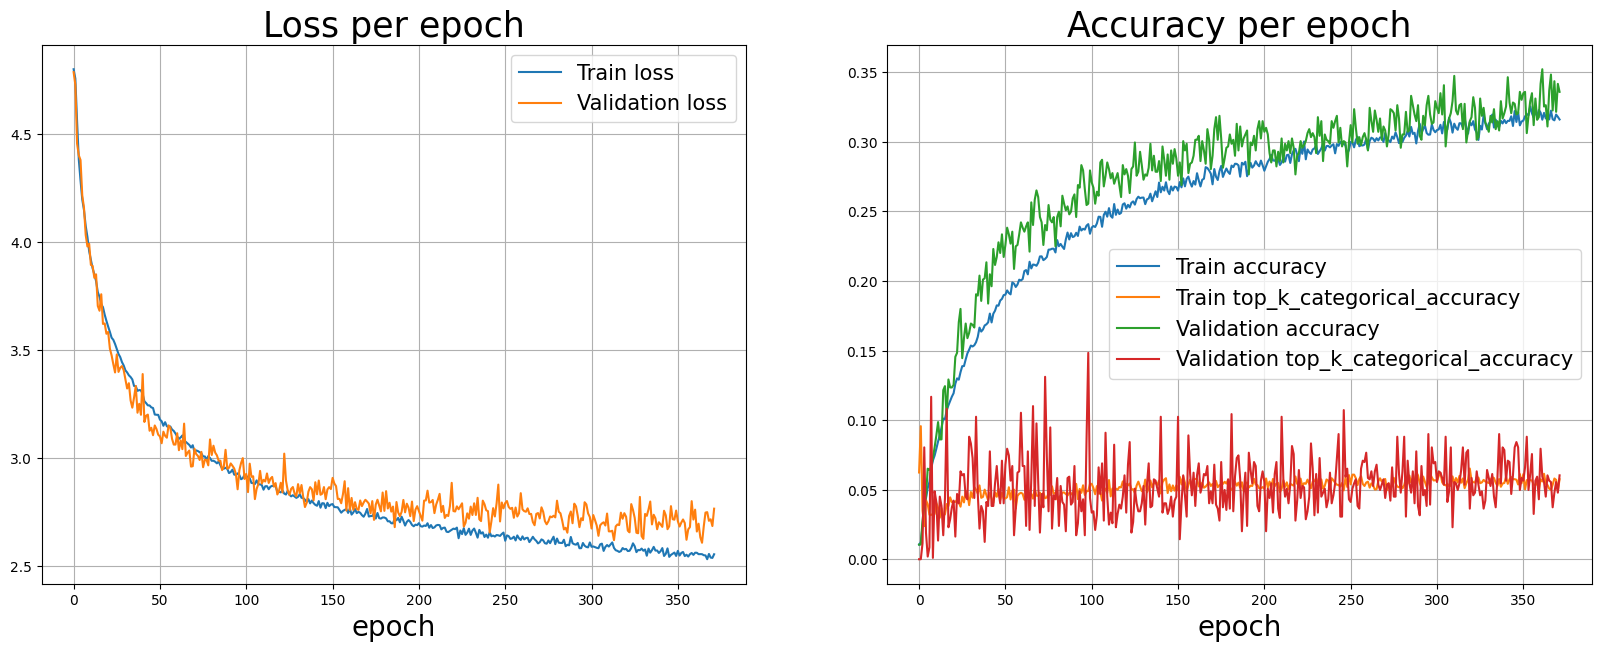

In [50]:
#display("Model summary:")
#model.summary()

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest loss/accuracy: %s - %s' % (test_loss, test_acc))

plot_results(all_history)

In [41]:
#for img, lbl in labeled_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).take(1):
to_show_imgs = []
to_show_predicted = []
to_show_true_label = []
all_predicted = []
all_true_labels = []
true_predicted_count = np.zeros((NB_CLASSES, NB_CLASSES))
errors = 0
total = 0
for img, lbl in test_ds:
    try:
        inp = tf.reshape(img, (BATCH_SIZE, RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS))
        result = np.argmax(model.predict(inp), axis=1)
        for (i, l, r) in zip(img, lbl, result):
            total += 1
            all_predicted.append(r)
            all_true_labels.append(l)
            true_predicted_count[l][r] += 1
            if l != r:
                errors += 1
                to_show_imgs.append(i)
                to_show_predicted.append(r)
                to_show_true_label.append(l)
    except:
        # Ignore the last batch which will not be of size 32
        pass

print("%s bad predictions out of %s (accuracy = %.2f%%)" % (errors, total, 100*(total-errors)/total))

1/1 [==============================] - 0s 69ms/step
1459 bad predictions out of 1984 (accuracy = 26.46%)


In [42]:
import math

avg_precision = 0
avg_recall = 0
details = pd.DataFrame(columns=['id', 'precision','recall'], index=[label_str(x) for x in range(NB_CLASSES)])

for l in range(NB_CLASSES):
    precision = recall = 0
    if sum(true_predicted_count[:,l]) != 0:
        precision = 100*true_predicted_count[l][l]/sum(true_predicted_count[:,l])
    if sum(true_predicted_count[l]) != 0:
        recall = 100*true_predicted_count[l][l]/sum(true_predicted_count[l])
    details.loc[label_str(l)] = pd.Series({'id': l, 'precision': precision, 'recall': recall})
    avg_precision += precision
    avg_recall += recall
    
avg_precision /= NB_CLASSES
avg_recall /= NB_CLASSES

print("")
print("Avg precision = %.2f%%, Avg recall = %.2f%%" % (avg_precision, avg_recall))
print("")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(details)


Avg precision = 25.90%, Avg recall = 25.97%



id  precision     recall
Tibetan_terrier                   0.0  28.571429  11.111111
English_setter                    1.0        0.0        0.0
keeshond                          2.0  34.482759  55.555556
basenji                           3.0   21.73913  38.461538
Pembroke                          4.0  38.095238       32.0
Siberian_husky                    5.0  10.526316       10.0
soft-coated_wheaten_terrier       6.0       20.0  11.111111
Kerry_blue_terrier                7.0  11.627907       50.0
Cardigan                          8.0  14.285714   7.142857
Maltese_dog                       9.0  39.215686  64.516129
Saint_Bernard                    10.0      43.75       50.0
Labrador_retriever               11.0  21.428571  16.666667
bull_mastiff                     12.0  21.052632  33.333333
Boston_bull                      13.0  18.181818       37.5
Chihuahua                        14.0        0.0        0.0
komondor                         15.0  47.368421  64.285714
Blenheim_spaniel                 16.0       50.0       62.5
miniature_poodle                 17.0        0.0        0.0
whippet                          18.0  16.666667   8.695652
beagle                           19.0  14.285714  13.043478
kuvasz                           20.0  33.333333  27.272727
English_springer                 21.0  21.052632  57.142857
Norwich_terrier                  22.0  10.526316       10.0
Gordon_setter                    23.0  27.777778  35.714286
otterhound                       24.0  33.333333  23.076923
dhole                            25.0       16.0  22.222222
Scottish_deerhound               26.0       20.0  34.782609
African_hunting_dog              27.0  31.578947       40.0
groenendael                      28.0        0.0        0.0
silky_terrier                    29.0  17.241379  41.666667
Samoyed                          30.0  83.333333       25.0
Chesapeake_Bay_retriever         31.0  12.820513  33.333333
miniature_schnauzer              32.0  27.586207  47.058824
Australian_terrier               33.0  23.529412  22.222222
Lakeland_terrier                 34.0       50.0  16.666667
Great_Pyrenees                   35.0       30.0  27.272727
cairn                            36.0   4.347826       6.25
Appenzeller                      37.0        0.0        0.0
Border_collie                    38.0       20.0      18.75
papillon                         39.0  28.571429       20.0
Yorkshire_terrier                40.0  33.333333  11.111111
Dandie_Dinmont                   41.0  15.151515  27.777778
schipperke                       42.0  27.777778  33.333333
Border_terrier                   43.0       37.5       37.5
redbone                          44.0       25.0       6.25
Shetland_sheepdog                45.0  17.241379  41.666667
malinois                         46.0        0.0        0.0
toy_terrier                      47.0       80.0       32.0
German_short-haired_pointer      48.0  41.666667  33.333333
wire-haired_fox_terrier          49.0       50.0  16.666667
toy_poodle                       50.0        0.0        0.0
standard_schnauzer               51.0        0.0        0.0
borzoi                           52.0  33.333333   7.692308
Shih-Tzu                         53.0  16.666667        5.0
Irish_setter                     54.0  15.384615  13.333333
dingo                            55.0       20.0   7.142857
Sussex_spaniel                   56.0  28.947368  57.894737
bloodhound                       57.0       25.0  19.047619
Rottweiler                       58.0       37.5       20.0
basset                           59.0  30.434783       35.0
giant_schnauzer                  60.0  27.272727  17.647059
Leonberg                         61.0  30.434783  66.666667
bluetick                         62.0       50.0  35.294118
Tibetan_mastiff                  63.0       50.0   5.263158
English_foxhound                 64.0  33.333333       30.0
Great_Dane                       65.0        0.0        0.0
Eskimo_dog     

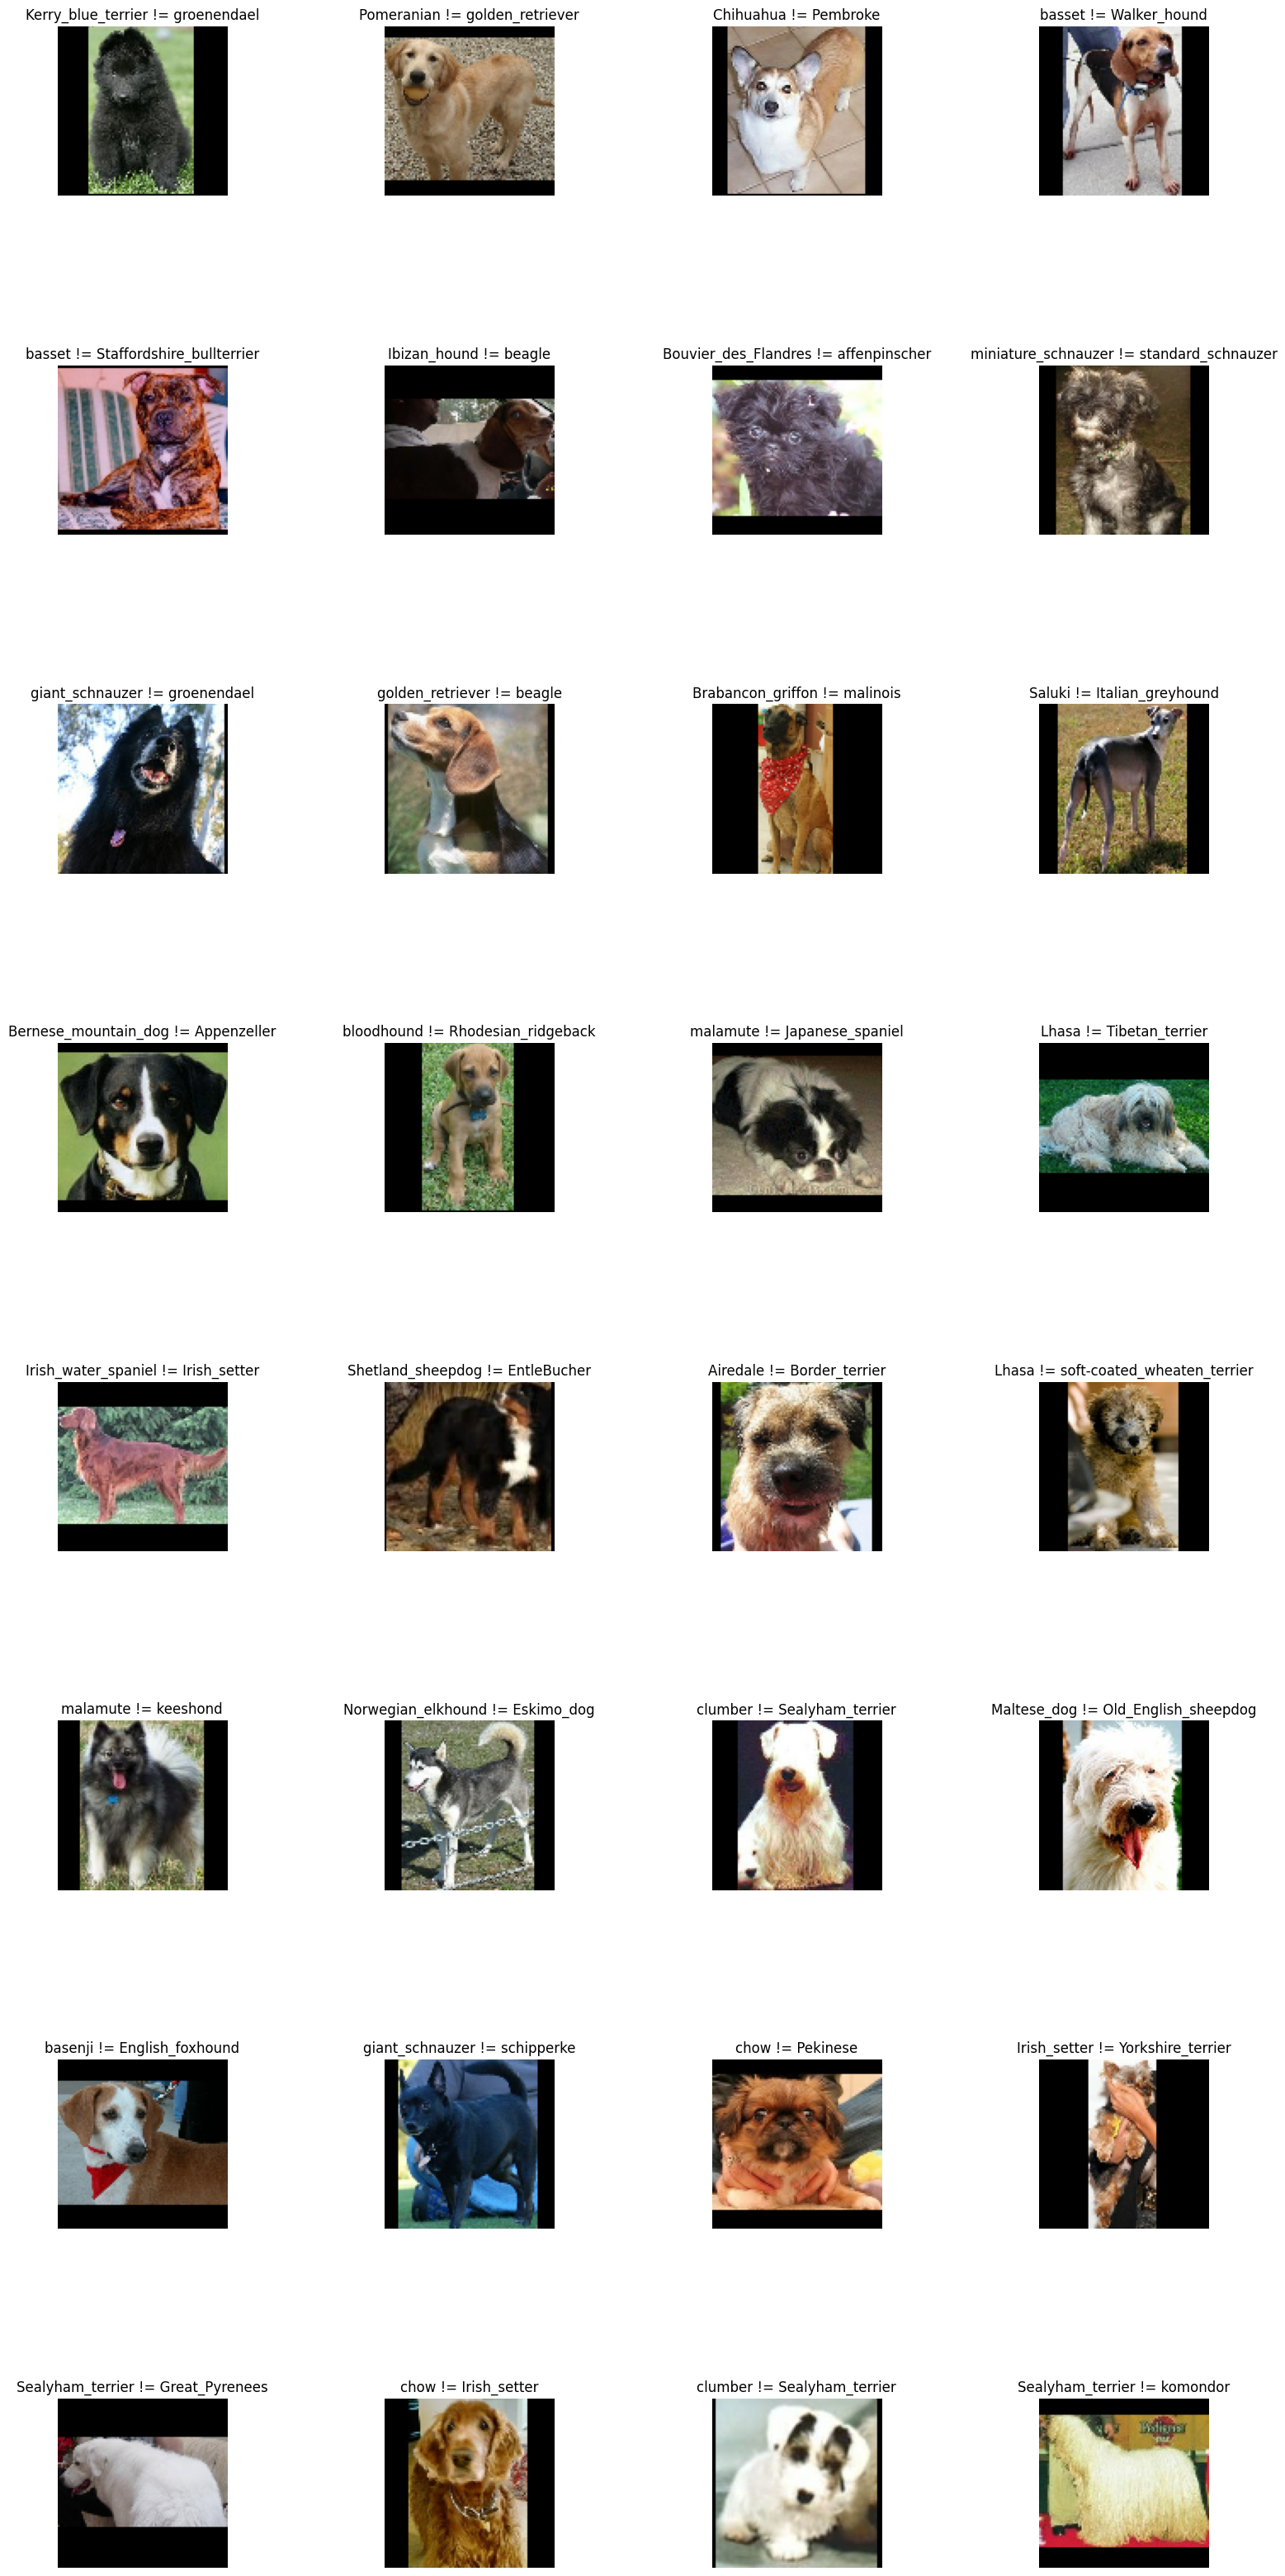

In [43]:
show_items(to_show_imgs, 4, 8, labels=to_show_predicted, true_labels=to_show_true_label)

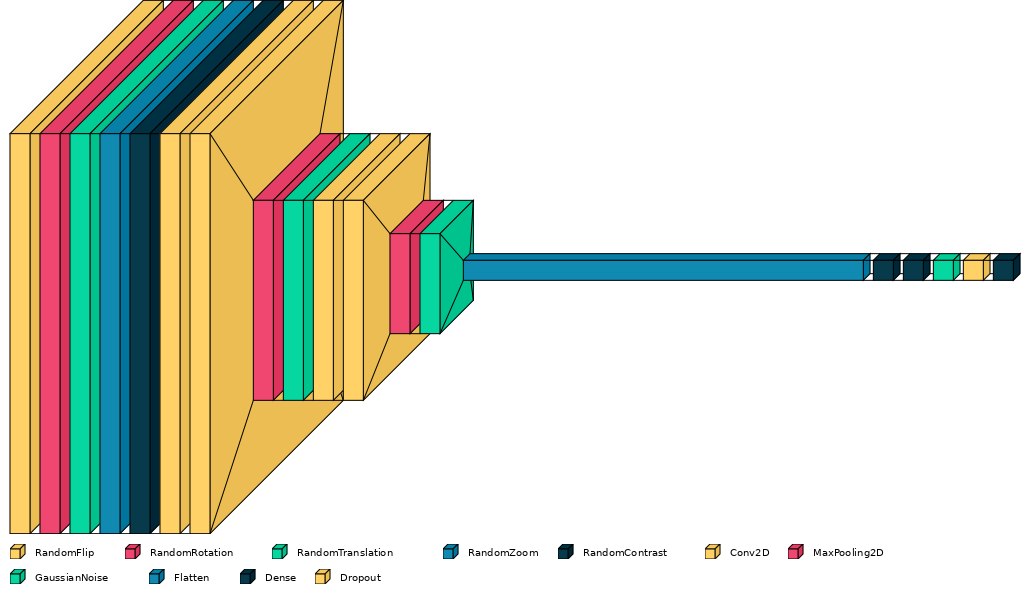

In [44]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 10, encoding="unic")
# A hack to make the legend work because getsize has been removed from Pillow but visualkeras wasn't updated:
# https://github.com/tensorflow/models/issues/11040
font.getsize = lambda str: [8*len(str), 10]

visualkeras.layered_view(model, legend=True, font=font).convert('RGB')

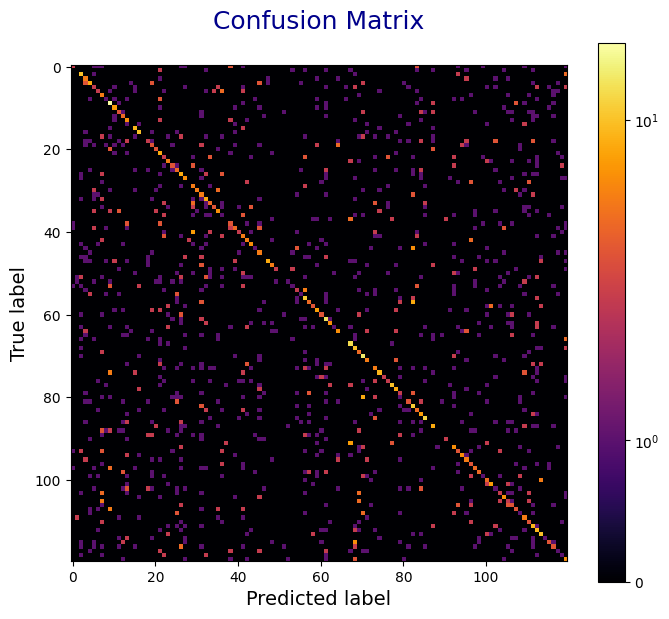

In [51]:
def plot_confusion_matrix(real, predictions, names):
    raw_confusion = tf.math.confusion_matrix(real, predictions)
    # Remove the diagonal
    #confusion = confusion - np.diag(np.diag(confusion))
    
    confusion = pd.DataFrame(
        data=raw_confusion,
        index=names,
        columns=names,
    )
    #display(confusion)
    plt.figure(figsize = (8,7), facecolor='white')
    plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)
    #plt.xticks(range(NB_CLASSES), labels, size='small')
    #plt.yticks(range(NB_CLASSES), labels, size='small')
    plt.imshow(confusion, cmap='inferno', norm='symlog')
    #for y, row in enumerate(raw_confusion):
    #    for x, v in enumerate(row):
    #        color = 'white' if v.numpy() < 100 else 'black'
    #        plt.text(x, y, v.numpy(), color=color, horizontalalignment='center', verticalalignment='center')
    plt.colorbar(ticks=[0, 1, 10, 100, 1000])
    plt.show()

plot_confusion_matrix(all_true_labels, all_predicted, labels)